Image manipulation demonstration created by Alex Frye, for use in Dr. Hoover's EE/CENG 441/541 Computer Vision class

In [1]:
import skimage
from skimage import io
from skimage import data
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import time
from scipy import signal
from scipy import linalg
from skimage.transform import resize
from scipy.ndimage import gaussian_filter

from Lab3_lib import *

In [2]:
header = 'P4Images/'
im_per_group = [64, 128]
im_maj_groups = ['TestImages/', 'TrainingImages/']
im_min_groups = ['Boat', 'Cabinet', 'Car', 'Chair', 'Cup', 'FlashLight', 'Handle', 'HoseReel',
                'ibook01', 'imac04', 'imac98', 'Keyboard', 'LED', 'Light1', 'Light2',
                'Mug', 'Scooter', 'SprayBottle', 'Stapler', 'Trash']
im_proc = ['Unprocessed/', 'Processed/']
im_size = ['32/', '64/']
im_head = 'img_'
im_foot = '.png'
im_ans = 'RandAng.txt'

# Grab testing data
im_testing = []
for i in range(len(im_min_groups)):
    im_testing.append([])
    for j in range(im_per_group[0]):
        head = header + im_maj_groups[0] + im_min_groups[i] + im_size[0] + im_proc[0] + im_head
        temp = io.imread(head + str(j) + im_foot, as_gray = True)
        im_testing[i].append(temp)

# Grab testing answers
im_testing_ans_str = header + im_maj_groups[0] + im_ans
with open (im_testing_ans_str, "r") as myfile:
    data=myfile.read()

im_testing_ans = data.split(',')
for i in range(len(im_testing_ans)):
    im_testing_ans[i] = float(im_testing_ans[i])

# Grab training data
im_training_proc = []
im_training_unproc = []
for i in range(len(im_min_groups)):
    im_training_proc.append([])
    im_training_unproc.append([])
    for j in range(im_per_group[1]):
        head = header + im_maj_groups[1] + im_min_groups[i] + im_size[1] + im_proc[0] + im_head
        temp = io.imread(head + str(j) + im_foot, as_gray = True)
        im_training_unproc[i].append(temp)
        
        head = header + im_maj_groups[1] + im_min_groups[i] + im_size[1] + im_proc[1] + im_head
        temp = io.imread(head + str(j) + im_foot, as_gray = True)
        im_training_proc[i].append(temp)

# Compute training answers
im_training_ans = np.linspace(0, 2*np.pi, 128)

In [3]:
def un_bias_image_sets(im_array):
    num_sets = np.shape(im_array)[0]
    num_im = np.shape(im_array)[1]
    im_array_unbiased = np.zeros(np.shape(im_array))
    for i in range(num_sets):
        im_norm = np.zeros((np.shape(im_array)[2], np.shape(im_array)[3]))
        for j in range(num_im):
            im_norm += im_array[i][j] / num_im
        for j in range(num_im):
            im_array_unbiased[i][j] = im_array[i][j] - im_norm
    return im_array_unbiased

def x_from_image_sets(images):
    num_sets = np.shape(images)[0]
    num_im = np.shape(images)[1]
    dim0 = np.shape(images)[2]
    dim1 = np.shape(images)[3]
    x = np.zeros((num_sets,dim0*dim1,num_im), dtype=np.float32)
    for i in range(num_sets):
        for j in range(num_im):
            x[i][:,j] = images[i][j].reshape(dim0*dim1)
    return x
    
def u_sv_from_x(x):
    num_sets = np.shape(x)[0]
    num_pix = np.shape(x)[1]
    num_im = np.shape(x)[2]
    u = np.zeros((num_sets,num_pix,num_im), dtype=np.float32)
    sv = np.zeros((num_sets,num_im), dtype=np.float32)
    for i in range(num_sets):
        u[i], sv[i], vt = np.linalg.svd(x[i], full_matrices=False)
    return np.array(u), np.array(sv)

def m_from_u_x(u, x, k=None):
    if k is None:
        k = np.shape(x)[2]
    num_sets = np.shape(x)[0]
    num_im = np.shape(x)[2]
    m = np.zeros((num_sets,k,num_im))
    for i in range(num_sets):
        m[i] = u[i,:,0:k].T @ x[i]
    return m

def g_u_sv_m_from_x(x, k=None):
    if k is None:
        k = np.shape(x)[2]
        
    num_sets = np.shape(x)[0]
    num_pix = np.shape(x)[1]
    num_im = np.shape(x)[2]
    
    g = np.zeros((num_sets*num_im,num_pix), dtype=np.float32)
    #u = np.zeros((num_sets*num_im,num_pix), dtype=np.float32)
    #sv = np.zeros((num_sets*num_im), dtype=np.float32)
    #m = np.zeros((num_sets*num_im,k), dtype=np.float32)
    for i in range(num_sets):
        for j in range(num_im):
            g[(i+1)*j] = x[i,:,j]
    u, sv, vt = np.linalg.svd(g, full_matrices=False)
    m = u[:,0:k].T @ x
    return g, u, sv, m
    
def plot_3d_manifold(m, num=None):
    if num is None:
        M = m
    else:
        M = m[num]

    fig = plt.figure()
    fig.suptitle('3D manifold Pose for set ' + str(0))
    ax = plt.axes(projection='3d')
    ax.plot3D(M[0,:], M[1,:], M[2,:],'blue')
    ax.scatter3D(M[0,:], M[1,:], M[2,:],color='red')
    ax.set_xlabel('$\phi_1$')
    ax.set_ylabel('$\phi_2$')
    ax.set_zlabel('$\phi_3$')

In [4]:
x = np.array(x_from_image_sets(im_training_unproc))
u, sv = u_sv_from_x(x)
m = m_from_u_x(u, x)

In [5]:
#g, ug, svg, mg = g_u_sv_m_from_x(x)

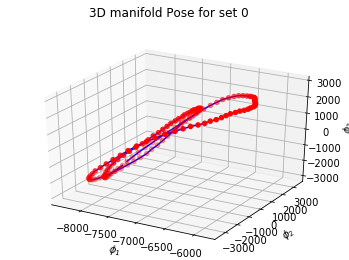

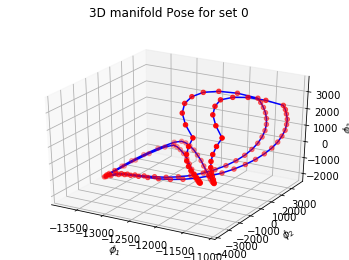

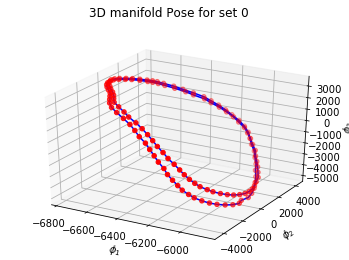

In [6]:
plot_3d_manifold(m, 0)
plot_3d_manifold(m, 1)
plot_3d_manifold(m, 2)

(16384, 128)
(16384, 128)
(128,)
(3, 128)


Text(0.5, 0, '$\\phi_3$')

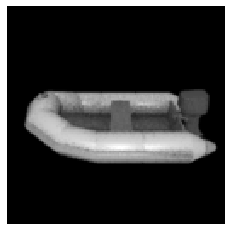

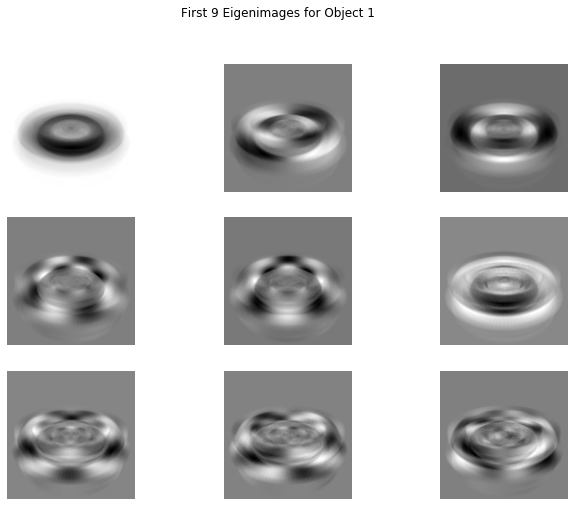

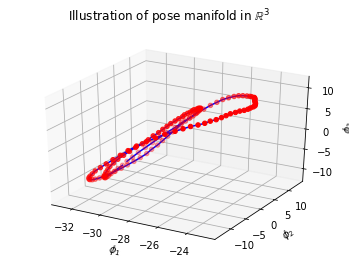

In [7]:
""" Let's load up some images, reshape them to "vectors", and construct the image data matrix X.
Recall, for this project you do not need to unbias the images, I would recommend just using X for 
everything instead of X_hat """
n = 128
X = np.zeros((128**2,0))
for i in range(n):
    Img = io.imread('P4Images/TrainingImages/Boat64/UnProcessed/img_' + str(i) + '.png', as_gray = True)
    Img = skimage.img_as_float32(Img).reshape(128**2,1)
    #Ivec = Img.reshape(128**2,1)
    X = np.hstack((X,Img))

print(np.shape(X))
"""Plot one of the images in X just to be sure things look okay  """
plt.figure(1)
plt.imshow(X[:,0].reshape(n,n), cmap='gray')
plt.axis('off')

"""  Now that we have the Image data matrix (X), we need to compute the eigenvectors of 
the sample covariance matrix (1/n * X * X^T), recall that we can efficiently do this
via the Singular Value Decomposition.  We want to set "full_matrices = False" becasue
we only care about the first 128 coluns of U (the remaining colums simply span the Nullspace of X)"""
U,S,Vt = np.linalg.svd(X,full_matrices=False)
print(np.shape(U))
print(np.shape(S))
ajacent_images(U)

"""  The "eigenimages"" are exactly the columns of U (they just need to be reshaped back to image format) """
fig = plt.figure(2)
fig.suptitle('First 9 Eigenimages for Object 1')
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.axis('off')
    plt.imshow(U[:,i].reshape(n,n),cmap='gray')

"""  Next let's go ahead and compute the low-dimensional manifold by projecting
the image data back down to a 3-dimensional subspace.

Note 1:  You will likely need
more than 3-dimensions for pose estimation - we just use 3-dimensions so we can 
actually visualize what's going on here. 

Note 2:  Each red dot corresponds to one of the images of object 1 in the low-dimenisonal subspace.
For pose estimation, youd get a new test image, reshape it to a vector, compute p=U[:,0:k].T@Ivec
where in this case, k would be the subspace dimension determined by the energy recovory ratio.
p in this case will be a new k-dimensional point you can compare to each point on the manifold 
(compute the distance between p and all the other points).  The closest point on the manifold to p will
be the estimate of the pose."""
k = 3 #subspace dimension for visualization
M = U[:,0:k].T@X
print(np.shape(M))

fig = plt.figure(3)
fig.suptitle('Illustration of pose manifold in $\mathbb{R}^3$')
ax = plt.axes(projection='3d')
ax.plot3D(M[0,:], M[1,:], M[2,:],'blue')
ax.scatter3D(M[0,:], M[1,:], M[2,:],color='red')
ax.set_xlabel('$\phi_1$')
ax.set_ylabel('$\phi_2$')
ax.set_zlabel('$\phi_3$')

In [8]:
np.allclose(X, x[0])

False

Part 2

In [62]:
def computeER(x, sv, goal=None):
    x_norm = np.linalg.norm(x)**2
    data = []
    for i in range(len(sv)):
        ER = np.sum(sv[0:i]**2) / x_norm
        if goal is not None and ER > goal:
            print(ER)
            return i
        elif goal is None:
            data.append([i, ER])
    
    return data

def plotER(data, nums, max_k = 128):
    fig = plt.figure()
    fig.suptitle('Energy recovery ratio vs. basis dimension')
    ax = plt.axes()
    legend_arr = []
    for num in nums:
        x, y = np.hsplit(np.array(data[num]), 2)
        ax.plot(x[0:max_k], y[0:max_k])
        legend_arr.append('Object ' + str(num))
    fig.legend(legend_arr)

In [63]:
data = []
for i in range(20):
    print(computeER(x[i], sv[i], 0.9))
    data.append(computeER(x[i], sv[i]))

0.9069151571234889
7
0.9116806724514471
1
0.9026421775447495
4
0.9086292447873269
8
0.9129857849895041
3
0.9133858355291108
6
0.90394426591471
6
0.9050857209923654
11
0.9048480956075394
6
0.9100023162461482
10
0.9044171152419188
13
0.9057184704882526
21
0.9037254602779071
2
0.9032872967831395
5
0.9068675596299117
15
0.9048946103971495
2
0.9032420421982041
12
0.9127735389454541
2
0.9092098866784933
5
0.932333695685305
1


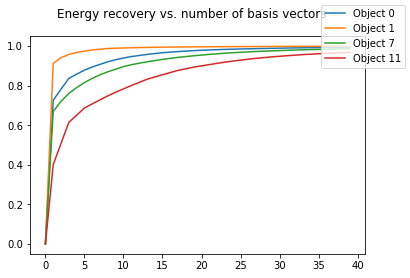

In [65]:
plotER(data, [0, 1, 7, 11], 40)